In [1]:
from boto.s3.connection import S3Connection
import pyart
import gzip
from matplotlib import pyplot as plt
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


In [2]:
def nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    """
    
    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data
    
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site
    
    #Connect to the bucket
    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')
    
    #Get a list of files 
    
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)
    #we are going to create a list of keys and datetimes to allow easy searching
    
    keys = []
    datetimes = []
    
    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-3]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            #print(dt)
        if this_str[-3::] == 'V06': #'LSX20160707_000150_' does not match format '%Y%m%d_%H%M%S_V06'
            #print(this_str)
            #print(this_str[-19::])
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #function to allow easy searching 
    
    def func(x):
        delta =  x - datetime_t if x > datetime_t else timedelta.max
        return delta
    
    #find the closest available radar to your datetime 
    
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    #print(closest_datetime)
    #create a temp file, download radar data to file from S3
    #read into a radar object and return
    
    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

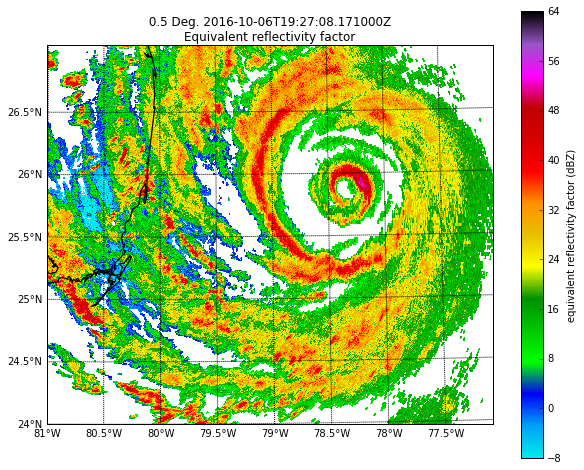

In [9]:
b_d = datetime(2016,10,6,19,28 ) #datetime.utcnow() #datetime.strptime(base_date, fmt)

my_radar = get_radar_from_aws('KAMX',b_d )
max_lat = 27
min_lat = 24
min_lon = -81
max_lon = -77

lal = np.arange(min_lat, max_lat, .5)
lol = np.arange(min_lon, max_lon, .5)

display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'i',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)

In [10]:
nyq = my_radar.instrument_parameters['nyquist_velocity']['data'][1]
print(nyq)
print(my_radar.fields['velocity']['data'].max())

8.34
33.0


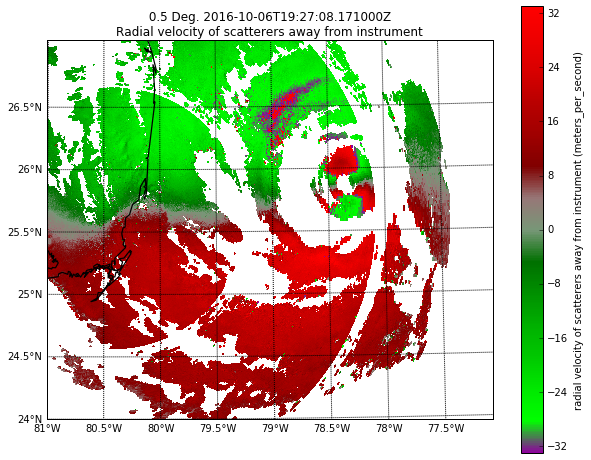

In [11]:
display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity', sweep = 1, resolution = 'i',
                    vmin = -33.01, vmax = 33.01, mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)

In [12]:
gatefilter = pyart.correct.GateFilter(my_radar)
gatefilter.exclude_masked('reflectivity')
corr_vel = pyart.correct.dealias_region_based(
    my_radar, vel_field='velocity', keep_original=False, 
    gatefilter = gatefilter, nyquist_vel=33.01, centered = True)
my_radar.add_field('corrected_velocity', corr_vel, replace_existing = True)

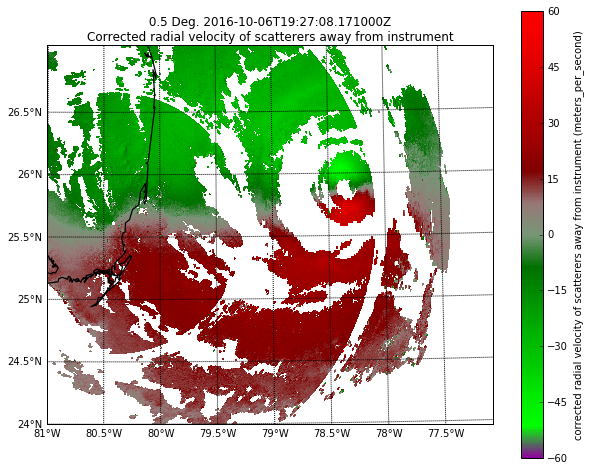

In [13]:

display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('corrected_velocity', sweep = 1, resolution = 'i',
                    vmin = -60, vmax = 60, mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)